In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import gc
import sys
import torchvision.datasets as dts 
import torchvision.transforms as transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as dat
import itertools as it

from torcheval.metrics.functional import binary_auroc
from torcheval.metrics.functional import binary_accuracy

from ACDNN import *

In [2]:
def make_non_uniform_alphas(x, smoothing_ratio=0.01, return_probability_dist=True):
    B, C, H, W, D = x.shape
    pool_width = int(H*smoothing_ratio)*2+1
    step_multiplier = 1.1
    noise_magnitude = 1
    normal_dist = torch.distributions.Normal(0,1)
    base = torch.zeros((B, 1, H, W, D), device=device)
    dimensions = H
    while int(dimensions) > 0:
        rand = torch.empty((B, 1, int(dimensions), int(dimensions), int(dimensions)), device=device).normal_(0,1) * noise_magnitude
        base += F.interpolate(rand, (int(H), int(H), int(H)), mode="trilinear")
        dimensions = dimensions/step_multiplier
        noise_magnitude *= step_multiplier

    base = base.reshape(B, H, W, D)
    base = F.avg_pool3d(base, pool_width,1, padding=pool_width//2, count_include_pad=False)
    base = base - base.mean(axis=[1,2,3]).reshape(-1,1,1,1)
    base = base / base.std(axis=[1,2,3]).reshape(-1,1,1,1)
    
    if return_probability_dist:
        dist = normal_dist.cdf(base)
        dist = dist - dist.min(axis=1)[0].unsqueeze(1)
        dist = dist / dist.max(axis=1)[0].unsqueeze(1)
        return dist
    else:
        return base

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'adrenalmnist3d'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
def evaluate_model(model, dlr, test_batches=50, smoothing_radius=0, use_auc=False):
    test_criterion = nn.CrossEntropyLoss(reduction='none')
    
    with torch.no_grad():
        gc.collect()
        torch.cuda.empty_cache()
        model.eval()
        torch.manual_seed(0)

        outputs = []
        targets = []
        for test_iter, test_batch in enumerate(dlr):
            if test_iter >= test_batches:
                break

            loss_list = []
            x_test, y_test = test_batch
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).long()
            
            output = F.softmax(model(x_test), dim=1)
            #losses.append(test_criterion(output, y_test.repeat(1,model.n_outputs)))
            outputs.append(output[:,1,:])
            targets.append(y_test.repeat(1,model.n_outputs).float())

        outputs = torch.cat(outputs, axis=0).float()
        targets = torch.cat(targets, axis=0).float()

        if use_auc:
            results = binary_auroc(outputs.T, targets.T, num_tasks=outputs.shape[1]).reshape(1,-1)
        else:
            results = (outputs.round() == targets).float().mean(axis=0).reshape(1,-1)
        
        losses = F.avg_pool1d(results, kernel_size=smoothing_radius*2+1,stride=1, padding=smoothing_radius, count_include_pad=False).mean(axis=0).cpu().numpy()
        
        return losses

In [6]:
def train_model(train, val, test, epochs, model, checkpoint_filename="binary_model.pyt",
                lr=1e-4, scheduler_patience=10, test_batches = 10, iters_between_test = 10,
                min_complexity_target=0, initial_wd=1, smoothing_value=0.1, smoothing_radius=0,
                evaluate_using_auc=False):

    test_criterion = nn.CrossEntropyLoss(reduction='none')
    criterion = nn.CrossEntropyLoss(label_smoothing=smoothing_value)
    
    model.train()
    iters = len(train)
    losses_val = None
    losses_test = None
    running_train_loss = []
    
    #training epochs
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=initial_wd)
    scaler = torch.amp.GradScaler("cuda")
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=int(iters), div_factor=1e4, pct_start=0.1)
    for epoch in range(epochs):
        #set seed here, seed is set again at test. 
        #If not reset after test this leads to overfitting since noise is the same each epoch
        torch.manual_seed(np.random.randint(99999999))
        model.train()
        gc.collect()
        torch.cuda.empty_cache()
        
        #print("--------------------------------------\nEPOCH", epoch)
        
        pbar = tqdm(train)
        for iteration, batch in enumerate(pbar):
            x_train, y_train = batch
            x_train = x_train.to(device).float()
            y_train = y_train.to(device).long()
            
            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                output = model(x_train)
                #train loss
                loss = criterion(output, y_train.repeat(1,model.n_outputs))
    
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            
            running_train_loss.append(float(loss))
            running_train_loss = running_train_loss[-1000:]
            current_lr = optimizer.param_groups[0]['lr']
            current_wd = optimizer.param_groups[0]['weight_decay']

            pbar.set_description(f"Loss: {np.mean(running_train_loss):.4f} LR {current_lr:.7f} WD {current_wd:.2f}")
        
        
        model.eval()
        #losses_train = evaluate_model(model, train, test_batches=test_batches)
        losses_val = evaluate_model(model, val, test_batches=test_batches, use_auc=evaluate_using_auc, smoothing_radius=smoothing_radius)
        losses_test = evaluate_model(model, test, test_batches=test_batches, use_auc=evaluate_using_auc, smoothing_radius=smoothing_radius)

        model.train()
        torch.manual_seed(np.random.randint(99999999))
        gc.collect()
        torch.cuda.empty_cache()
            
    
    model.eval()
    return losses_test, losses_val, model

In [7]:
train_batch_size = 64
val_batch_size = 64
test_batch_size = 64

num_workers = 8

trnsform_train = transforms.Compose([])
trnsform = transforms.Compose([])

# load the data
train_dataset = DataClass(split='train', transform=trnsform_train, download=download)
val_dataset = DataClass(split='val', transform=trnsform, download=download)
test_dataset = DataClass(split='test', transform=trnsform, download=download)

#calculate weights
dlr = dat.DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
data = next(iter(dlr))
class_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=data[1].float().reshape(-1).numpy())

# encapsulate data into dataloader form
sampler = dat.RandomSampler(train_dataset, replacement=True, num_samples=1000000)
#sampler = dat.WeightedRandomSampler(class_weights, replacement=True, num_samples=100000)
train_loader = dat.DataLoader(dataset=train_dataset, sampler=sampler, batch_size=train_batch_size, num_workers=num_workers, persistent_workers=True)
val_loader = dat.DataLoader(dataset=val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = dat.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

Using downloaded and verified file: /home/tb/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/tb/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/tb/.medmnist/adrenalmnist3d.npz


In [8]:
print(train_dataset)

Dataset AdrenalMNIST3D of size 28 (adrenalmnist3d)
    Number of datapoints: 1188
    Root location: /home/tb/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'hyperplasia'}
    Number of samples: {'train': 1188, 'val': 98, 'test': 298}
    Description: The AdrenalMNIST3D is a new 3D shape classification dataset, consisting of shape masks from 1,584 left and right adrenal glands (i.e., 792 patients). Collected from Zhongshan Hospital Affiliated to Fudan University, each 3D shape of adrenal gland is annotated by an expert endocrinologist using abdominal computed tomography (CT), together with a binary classification label of normal adrenal gland or adrenal mass. Considering patient privacy, we do not provide the source CT scans, but the real 3D shapes of adrenal glands and their classification labels. We calculate the center of adrenal and resize the center-cropped 64mm×64mm×64mm volume into 28×28×28. The dataset is 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#Do a gridsearch for best results, this includes just one parameter combination for demonstration purposes with short training time
params = {"smoothing_value":[0],
         "initial_wd":[1]}

list_of_lists = []
for key in params:
    list_of_lists.append([(key, x) for x in params[key]])

for index, left_list in enumerate(list_of_lists):
    other_lists = (list_of_lists[0:index] + list_of_lists[index+1:])
    right_list = [i for sublist in other_lists for i in sublist]
    l = list(it.product(left_list, right_list))

print("-------------------PARAM LIST-----------------")
for item in l:
    print(item)
print("----------------------------------------------")

results = {}

#Just 1 train/test for now
num_cv = 3
for index, x in enumerate(l):
    print("----------------------------------------------------------")
    print(str(index+1)+"/"+str(len(l))+": ", x)
    print("----------------------------------------------------------")
   
    wd, sv = x
    wd = wd[1]
    sv = sv[1]

    results[x] = {}
    results[x]["val_score"] = [] 
    results[x]["test_score"] = [] 
    
    for i in range(num_cv):
        print("--------------------------------------")
        print("CV "+str(i))
        torch.manual_seed(i)
        np.random.seed(i)
        model = ACDNN3D(in_channels=1, n_out=2, starting_channels=16, max_channels=256, blocks=8, group_size=2, random_input_mask=False).to(device)
        #model = torch.compile(model)
        test_score, val_score, model = train_model(train_loader, val_loader, test_loader, model=model, epochs=1, test_batches = 1000,
                            checkpoint_filename="binary_model.pyt", iters_between_test=100, lr=1e-3, evaluate_using_auc=False,
                            initial_wd=wd, smoothing_value=sv)
        results[x]["val_score"].append(val_score.reshape(1,-1))
        results[x]["test_score"].append(test_score.reshape(1,-1))

    results[x]["val_score"] = np.concatenate(results[x]["val_score"]).mean(axis=0)
    results[x]["test_score"] = np.concatenate(results[x]["test_score"]).mean(axis=0)
    best_score_index = results[x]["val_score"].argmax()

    print("--------------------------FINAL SCORE FOR KEY--------------------------------------")
    print(x)
    print("VAL SCORE ", results[x]["val_score"][best_score_index])
    print("TEST SCORE", results[x]["test_score"][best_score_index])
    print("-----------------------------------------------------------------------------------")

-------------------PARAM LIST-----------------
(('initial_wd', 1), ('smoothing_value', 0))
----------------------------------------------
----------------------------------------------------------
1/1:  (('initial_wd', 1), ('smoothing_value', 0))
----------------------------------------------------------
--------------------------------------
CV 0


  0%|          | 0/15625 [00:00<?, ?it/s]

--------------------------------------
CV 1


  0%|          | 0/15625 [00:00<?, ?it/s]

--------------------------------------
CV 2


  0%|          | 0/15625 [00:00<?, ?it/s]

--------------------------FINAL SCORE FOR KEY--------------------------------------
(('initial_wd', 1), ('smoothing_value', 0))
VAL SCORE  0.8605442
TEST SCORE 0.8299777
-----------------------------------------------------------------------------------


In [11]:
x = results[(("initial_wd", 1), ("smoothing_value", 0))]

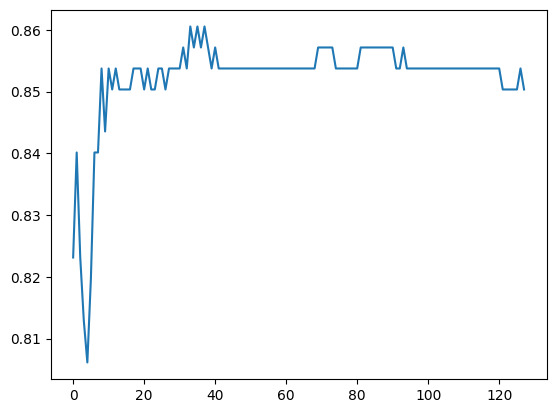

In [12]:
plt.plot(x["val_score"])

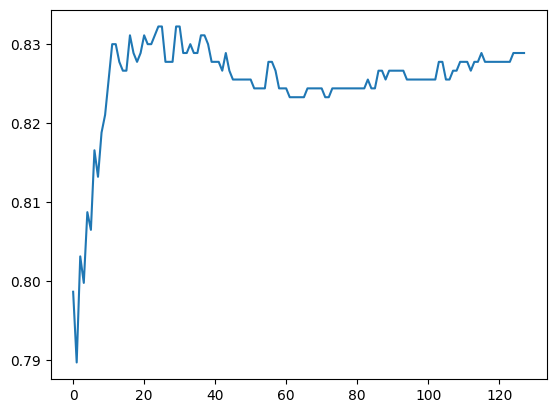

In [13]:
plt.plot(x["test_score"])